<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Table-of-Contents" data-toc-modified-id="Table-of-Contents-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Table of Contents</a></span></li><li><span><a href="#Issue-11" data-toc-modified-id="Issue-11-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Issue 11</a></span></li><li><span><a href="#Import-Issues" data-toc-modified-id="Import-Issues-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import Issues</a></span><ul class="toc-item"><li><span><a href="#Byte-Compiling" data-toc-modified-id="Byte-Compiling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Byte Compiling</a></span></li><li><span><a href="#Reloading" data-toc-modified-id="Reloading-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Reloading</a></span></li></ul></li></ul></div>

# Issue 11

In [1]:
from persist.archive import Archive
x = [1, 2, 3]
y = [x, x]
a = Archive(scoped=False)
a.insert(y=y)
s = str(a)
d = {}
exec(s, d)
y_ = d['y']
assert y[0] is y[1]
assert y_[0] is y_[1]

After a bit of inspection, I found that the problem occurs at the reduction state.  The call to `Graph.reduce()` is a bit too eager.  Need to find out why.  (Found a few bugs in the constructors for `Graph` and `Graph_` which should be similar...)


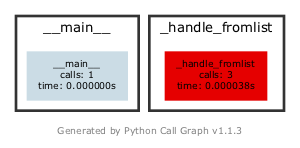

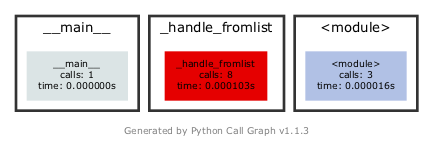

In [3]:
from IPython.display import Image, display
import os
import sys
import trace

from persist.archive import Archive
x = [1, 2, 3]
y = [x, x]

from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput

images = []

a = Archive(scoped=True)
a.insert(y=y)
with PyCallGraph(output=GraphvizOutput()):
    s = str(a)
images.append(Image(filename='pycallgraph.png', width="20%"))
os.remove('pycallgraph.png')

a = Archive(scoped=False)
a.insert(y=y)
with PyCallGraph(output=GraphvizOutput()):
    s = str(a)
images.append(Image(filename='pycallgraph.png', width="20%"))    
os.remove('pycallgraph.png')

display(*images)

In [4]:
g = a._graph
g.nodes

AttributeError: 'Archive' object has no attribute '_graph'

In [5]:
# create a Trace object, telling it what to ignore, and whether to
# do tracing or line-counting or both.
tracer = trace.Trace(
    ignoredirs=[sys.prefix, sys.exec_prefix],
    trace=1,
    count=1)

# run the new command using the given tracer
tracer.run('str(a)')

# make a report, placing output in the current directory
r = tracer.results()
#r.write_results(show_missing=True, coverdir=".")

The question here is who is responsible for ensuring that objects are not duplicated?
* The method `get_persistent_rep_list()` uses two names... so not here (but still has the same object).


# Import Issues

The objective is to prevent the data from being loaded until `import ds.x` is called.  This allows multiple processes to work with data independently with a lock file being required only when changing the metadata in `_info_dict`.  To implement this we use the following trick suggested by [Alex Martelli](https://en.wikipedia.org/wiki/Alex_Martelli):

  * [Can modules have properties the same way that objects can?](https://stackoverflow.com/a/880550/1088938)

Such a module might look like this:
  
```python
import sys
import numpy as np
sys.modules[__name__] = np.array([0, 1, 2, 3])
```
 
or like this (if loaded from disk):
 
```python
import os.path
import sys
import numpy as np
datafile = os.path.splitext(__file__)[0] + "_data.npy"
sys.modules[__name__] = np.load(datafile)
```

This seems to work very nicely.  The imported array appears as part of the top-level module no matter how it is imported, and is only loaded when explicitly requested.

## Byte Compiling

There is very subtle issue with using the import mechanism for DataSets.  When updating an attribute of a DataSet, we change the corresponding `.py` file on disk.  However, if this change is made too quickly after importing the attribute, it is possible that the byte-compiled `.pyc` file might not be finished compiling until *after* the `.py` file is updated.  In this case, the `.py` file will have an earlier timestamp than the `.pyc` file and so python will incorrectly assume that the `.pyc` file is authoritative.

I do not see a good solution yet, so for now we use [`sys.dont_write_bytecode`](https://docs.python.org/2/library/sys.html?highlight=bytecode#sys.dont_write_bytecode):

* https://stackoverflow.com/a/154617

## Reloading

Reloading data can also be an issue when replacing modules.  For example, if we have a module `mod` and array `d` that is replaced, then what should `reload(mod)` do if `d` is updated on disk.

Our solution is the following:

* Delete all attributes like `mod.d` upon reload so that the user needs to re-import `mod.d` etc. This is done in the `__init__.py` file.
* This behaviour is inconstant with the normal python import machinery, so we only do it for objects that were specified with `single_item_mode`.  The reason we do it here is that the user cannot `reload(mod.d)` since this is an array.  If the user does not want this behaviour, then they can disable `single_item_mode`.
* The alternative behaviour might be to reload all data that has already been imported.  We might provide a flag for this later if requested.